## Table of Contents

0. Notebook Goals & Hebbia Assumptions
1. Setup & Configuration
2. Synthetic Document Universe
3. Distillation Task Types & Cost Model
4. Workload Zipf Reuse Model: Analyst Queries Over Documents
5. Baseline Policy: No Doc-Scoped Cache
6. Capacity-Limited Doc Cache (with Eviction)
7. Throughput / Latency Metrics
8. Sensitivity Analysis (Reuse Skew, Cache Size, Distill Cost)
9. Hebbia-Scale Interpretation
10. Limitations & Extensions


## 0. Notebook Goals & Hebbia-Flavored Assumptions

**Abstract.** This notebook is a toy model of how much compute and latency
Hebbia could save by caching document-scoped views produced by its
[Distillation Agent](https://www.hebbia.com/blog/inside-hebbias-deeper-research-agent)
when hedge-fund / LevFin teams repeatedly hammer the same filings, credit
agreements, and transcripts.

We only zoom in on the **Distillation slice** of the Deeper Research Agent:

- A research query fans out across planners, retrievers, doc analyzers,
  the Distillation Agent, and an Output Agent.
- The Distillation Agent compresses long docs and intermediate chains into
  compact structured views (90%+ context reduction) that are highly reusable.
- Hedge funds run many lines of questioning over the same core docs:
  10-Ks / 10-Qs, credit agreements, transcripts, investor decks, etc.

Question this notebook answers:

> If we cache distilled views per `(doc_id, task_type)` under a realistic
> analyst workload and Zipf-like reuse, how many tokens and how much latency
> can we avoid vs. “always distill fresh”?

The rest of the notebook:

1. Define a synthetic doc universe (lengths, types).
2. Define distillation tasks and per-doc/task cost.
3. Build a multi-analyst workload with Zipf reuse over docs.
4. Compute a **baseline** where the Distillation Agent never reuses work.
5. (Later) Layer on doc-scoped caches with eviction, TTL, and versioned keys.

## 1. Setup & Configuration

In [20]:
# 1.1 Imports & global config

import math
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)


@dataclass
class CostConfig:
    # Document universe
    n_docs: int = 500  # distinct docs in "Matrix"
    # Workload
    n_queries: int = 5_000  # total research queries
    min_docs_per_query: int = 1
    max_docs_per_query: int = 3
    min_tasks_per_doc: int = 1
    max_tasks_per_doc: int = 2
    # Zipf-like reuse skew for doc popularity (higher → more peaky)
    zipf_exponent: float = 1.1
    # Distillation token pricing (normalized)
    tokens_per_million_cost: float = 1.0  # 1 unit = cost of 1M tokens
    # Latency model for distillation calls
    base_latency_ms: float = 80.0
    per_1k_tokens_latency_ms: float = 12.0
    # Distillation cost coefficients
    alpha_min: float = 0.25  # min fraction of doc tokens
    alpha_max: float = 0.60  # max fraction
    beta_min: int = 150  # min summary length
    beta_max: int = 400  # max summary length


CFG = CostConfig()

In [21]:
# 1.2 Cost / latency helpers + small utilities


def token_cost(num_tokens: int, cfg: CostConfig = CFG) -> float:
    """Convert token count into a normalized dollar cost."""
    return (num_tokens / 1_000_000.0) * cfg.tokens_per_million_cost


def simulate_latency_ms(num_tokens: int, cfg: CostConfig = CFG) -> float:
    """Simple latency model: base + linear in tokens."""
    return cfg.base_latency_ms + (num_tokens / 1_000.0) * cfg.per_1k_tokens_latency_ms


def pretty_print_table(df: pd.DataFrame, index: bool = False):
    """Convenience printer for small summary tables."""
    display(df.style.format().hide(axis="index" if not index else None))

### 1.3 Cost & Latency Model

We track only **relative** cost / latency:

- `tokens_total = tokens_in + tokens_out`
- `cost = tokens_total / 1e6 * C`, with `C = 1.0`
- `latency_ms = L0 + L1 * (tokens_total / 1e3)`

This is enough to compare:

- Baseline (no reuse) vs.
- Cached policies (doc-scoped distillation reuse)

## 2. Synthetic Document Universe (Docs + Token Sizes)

In [22]:
# 2.1 Doc types + token length distributions

DOC_TYPES = [
    "CREDIT_AGREEMENT",
    "10K",
    "10Q",
    "TRANSCRIPT",
    "INVESTOR_DECK",
]

# Mean & sigma (log-space) for token lengths by doc type
DOC_LENGTH_PARAMS = {
    "CREDIT_AGREEMENT": {"mean_log": math.log(40_000), "sigma": 0.6},
    "10K": {"mean_log": math.log(25_000), "sigma": 0.5},
    "10Q": {"mean_log": math.log(12_000), "sigma": 0.5},
    "TRANSCRIPT": {"mean_log": math.log(10_000), "sigma": 0.5},
    "INVESTOR_DECK": {"mean_log": math.log(4_000), "sigma": 0.4},
}

# TTL horizon in "query steps": after ~TTL steps, a view is effectively stale.
DOC_TTL_STEPS = {
    "CREDIT_AGREEMENT": 10_000,
    "10K": 10_000,
    "10Q": 5_000,
    "TRANSCRIPT": 800,
    "INVESTOR_DECK": 400,
}

# Doc update rate per 1k queries: controls version churn.
DOC_UPDATE_RATE_PER_1K_QUERIES = {
    "CREDIT_AGREEMENT": 0.02,  # almost static
    "10K": 0.05,
    "10Q": 0.10,
    "TRANSCRIPT": 0.20,
    "INVESTOR_DECK": 0.30,
}


def sample_doc_length_tokens(doc_type: str) -> int:
    params = DOC_LENGTH_PARAMS[doc_type]
    length = np.random.lognormal(mean=params["mean_log"], sigma=params["sigma"])
    return int(max(1_000, min(length, 150_000)))


rows = []
for doc_id in range(CFG.n_docs):
    doc_type = random.choice(DOC_TYPES)
    length_tokens = sample_doc_length_tokens(doc_type)
    rows.append(
        {
            "doc_id": doc_id,
            "doc_type": doc_type,
            "doc_length_tokens": length_tokens,
        }
    )

df_docs = pd.DataFrame(rows)
df_docs.head()

,doc_id,doc_type,doc_length_tokens
0,0,CREDIT_AGREEMENT,53888
1,1,CREDIT_AGREEMENT,36815
2,2,10Q,16589
3,3,10K,53537
4,4,10K,22237


Document type counts:


count
107
106
101
98
88



Sample docs:


doc_id,doc_type,doc_length_tokens
361,10Q,25823
73,10K,54663
374,TRANSCRIPT,29346
155,10Q,8395
104,INVESTOR_DECK,3750


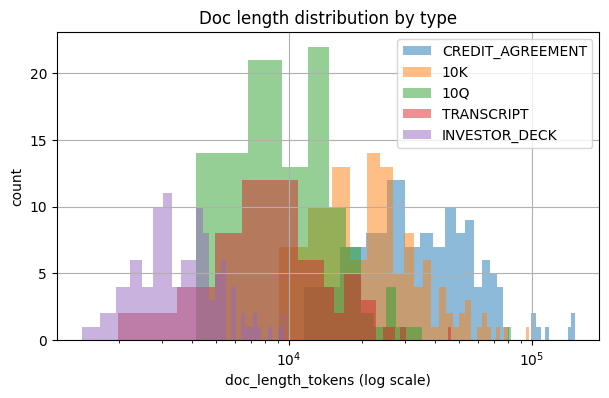

In [23]:
# 2.2 Inspect doc universe

print("Document type counts:")
pretty_print_table(df_docs["doc_type"].value_counts().to_frame("count"))

print("\nSample docs:")
pretty_print_table(df_docs.sample(5, random_state=RNG_SEED))

plt.figure()
for dt in DOC_TYPES:
    subset = df_docs[df_docs["doc_type"] == dt]
    if subset.empty:
        continue
    plt.hist(
        subset["doc_length_tokens"],
        bins=30,
        alpha=0.5,
        label=dt,
    )

plt.xscale("log")
plt.xlabel("doc_length_tokens (log scale)")
plt.ylabel("count")
plt.title("Doc length distribution by type")
plt.legend()
plt.show()

In [24]:
# 2.3 Precompute a "version timeline" per doc across query steps.
# Each (doc_id, step) gets a version_id; we increment when a new version arrives.


def build_doc_version_timeline(
    docs_df: pd.DataFrame,
    cfg: CostConfig,
) -> Dict[Tuple[int, int], int]:
    """
    For each doc_id and each query step t in [0, n_queries),
    sample a version_id that increments when a new version "arrives".
    """
    version_map: Dict[Tuple[int, int], int] = {}

    for row in docs_df.itertuples(index=False):
        doc_id = int(row.doc_id)
        doc_type = row.doc_type
        rate_per_1k = DOC_UPDATE_RATE_PER_1K_QUERIES[doc_type]
        p_update_per_step = rate_per_1k / 1000.0

        version = 0
        for t in range(cfg.n_queries):
            if np.random.rand() < p_update_per_step:
                version += 1
            version_map[(doc_id, t)] = version

    return version_map


DOC_VERSION_BY_STEP = build_doc_version_timeline(df_docs, CFG)

At this point we have:

- `df_docs`: `doc_id`, `doc_type`, `doc_length_tokens`
- `DOC_VERSION_BY_STEP[(doc_id, t)] → version_id` for each query step `t`

Version IDs will be used later when we define cache keys:
`(doc_id, doc_version, task_type)`.

## 3. Distillation Task Types & Cost Model

In [25]:
# 3.1 Distillation tasks per doc_type

DISTILLATION_TASKS_BY_TYPE: Dict[str, List[str]] = {
    "CREDIT_AGREEMENT": ["EXEC_SUMMARY", "COVENANTS", "TRAPDOOR_CAPACITY"],
    "10K": ["EXEC_SUMMARY", "RISK_FACTORS"],
    "10Q": ["EXEC_SUMMARY", "RISK_FACTORS"],
    "TRANSCRIPT": ["EXEC_SUMMARY", "GUIDANCE"],
    "INVESTOR_DECK": ["EXEC_SUMMARY", "GUIDANCE"],
}

# Task-specific "weight" inside the doc; drives alpha/beta sampling.
TASK_ALPHA_BIAS = {
    "EXEC_SUMMARY": 0.35,
    "COVENANTS": 0.45,
    "RISK_FACTORS": 0.40,
    "TRAPDOOR_CAPACITY": 0.50,
    "GUIDANCE": 0.30,
}

TASK_BETA_BIAS = {
    "EXEC_SUMMARY": 250,
    "COVENANTS": 300,
    "RISK_FACTORS": 280,
    "TRAPDOOR_CAPACITY": 320,
    "GUIDANCE": 220,
}

In [26]:
# 3.2 Precompute per-(doc_id, task_type) distillation cost

distill_rows = []

for _, row in df_docs.iterrows():
    doc_id = int(row["doc_id"])
    doc_type = row["doc_type"]
    doc_tokens = int(row["doc_length_tokens"])

    tasks = DISTILLATION_TASKS_BY_TYPE[doc_type]

    for task_type in tasks:
        base_alpha = TASK_ALPHA_BIAS[task_type]
        alpha = np.clip(
            np.random.normal(loc=base_alpha, scale=0.05),
            CFG.alpha_min,
            CFG.alpha_max,
        )

        base_beta = TASK_BETA_BIAS[task_type]
        beta = int(
            np.clip(
                np.random.normal(loc=base_beta, scale=30),
                CFG.beta_min,
                CFG.beta_max,
            )
        )

        tokens_in = int(alpha * doc_tokens)
        tokens_out = beta
        tokens_total = tokens_in + tokens_out

        distill_rows.append(
            {
                "doc_id": doc_id,
                "doc_type": doc_type,
                "task_type": task_type,
                "doc_length_tokens": doc_tokens,
                "alpha": alpha,
                "beta": beta,
                "tokens_in": tokens_in,
                "tokens_out": tokens_out,
                "tokens_total": tokens_total,
                "cost": token_cost(tokens_total, CFG),
                "latency_ms": simulate_latency_ms(tokens_total, CFG),
            }
        )

df_distill = pd.DataFrame(distill_rows)
df_distill.head()

,doc_id,doc_type,task_type,doc_length_tokens,alpha,beta,tokens_in,tokens_out,tokens_total,cost,latency_ms
0,0,CREDIT_AGREEMENT,EXEC_SUMMARY,53888,0.462280,262,24911,262,25173,0.025173,382.076
1,0,CREDIT_AGREEMENT,COVENANTS,53888,0.403726,321,21755,321,22076,0.022076,344.912
2,0,CREDIT_AGREEMENT,TRAPDOOR_CAPACITY,53888,0.495494,338,26701,338,27039,0.027039,404.468
3,1,CREDIT_AGREEMENT,EXEC_SUMMARY,36815,0.300184,223,11051,223,11274,0.011274,215.288
4,1,CREDIT_AGREEMENT,COVENANTS,36815,0.522831,268,19248,268,19516,0.019516,314.192


Number of distinct (doc_id, task_type) pairs: 1107

Average distillation cost by doc_type:


tokens_in,tokens_out,tokens_total,cost
10840.000000,265.000000,11105.000000,0.000000
5116.000000,263.000000,5379.000000,0.000000
20606.000000,293.000000,20900.000000,0.000000
1387.000000,235.000000,1622.000000,0.000000
3921.000000,233.000000,4155.000000,0.000000


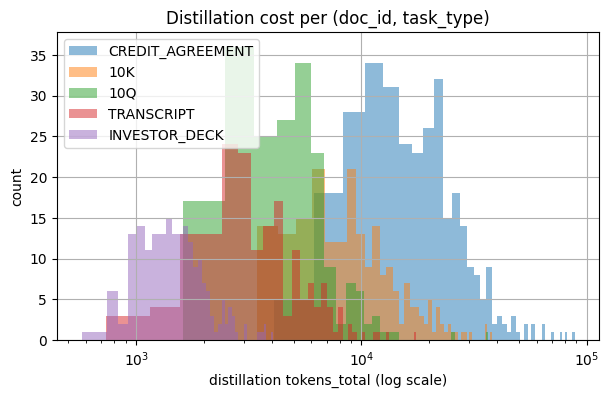

In [27]:
# 3.3 Inspect distillation cost distribution

print("Number of distinct (doc_id, task_type) pairs:", len(df_distill))

summary_by_doc_type = (
    df_distill.groupby("doc_type")[["tokens_in", "tokens_out", "tokens_total", "cost"]]
    .mean()
    .round(0)
)

print("\nAverage distillation cost by doc_type:")
pretty_print_table(summary_by_doc_type)

plt.figure()
for dt in DOC_TYPES:
    subset = df_distill[df_distill["doc_type"] == dt]
    if subset.empty:
        continue
    plt.hist(
        subset["tokens_total"],
        bins=40,
        alpha=0.5,
        label=dt,
    )

plt.xscale("log")
plt.xlabel("distillation tokens_total (log scale)")
plt.ylabel("count")
plt.title("Distillation cost per (doc_id, task_type)")
plt.legend()
plt.show()

Each `(doc_id, task_type)` now has a fixed one-shot distillation cost:

- `tokens_total`
- `cost`
- `latency_ms`

Caching policies later will decide **how many times** we pay this cost.

## 4. Workload Model: Analyst Queries Over Documents

Hebbia’s blog
[“How Hedge Funds Use Hebbia”](https://www.hebbia.com/blog/how-hedge-funds-use-hebbia)
describes recurring usage patterns:

- Ramping / expanding coverage on new names
- Value-chain / read-through analysis across issuers
- Guidance and tone comparisons across calls / decks
- Disruption / risk monitoring across sectors

All of these involve **repeatedly hitting the same core docs**:
recent 10-K/10-Qs, current credit agreements, earnings transcripts, decks.

We model:

- A small pool of analysts, each with a persona:
  `coverage`, `value_chain`, `guidance_tone`, `disruption`.
- A global Zipf popularity distribution over docs.
- Each query:
  - comes from one analyst / persona,
  - touches 1–3 docs,
  - requests 1–2 distillation tasks per doc (consistent with its type),
  - happens at a discrete step `t` so we can attach a `version_id`.

Core artifacts we build:

- `df_queries`: one row per query.
- `df_query_pairs`: one row per `(query_id, doc_id, doc_version, task_type)` usage.

In [28]:
# 4.1 Analyst personas, query archetypes, Zipf-like doc popularity

N_ANALYSTS = 24

ANALYST_PERSONAS = ["coverage", "value_chain", "guidance_tone", "disruption"]
PERSONA_WEIGHTS = np.array([0.35, 0.25, 0.25, 0.15])  # must sum to 1

# Assign each analyst a persona for the whole simulation
analyst_persona = {
    analyst_id: np.random.choice(ANALYST_PERSONAS, p=PERSONA_WEIGHTS)
    for analyst_id in range(N_ANALYSTS)
}

analyst_persona

{0: np.str_('disruption'),
 1: np.str_('disruption'),
 2: np.str_('guidance_tone'),
 3: np.str_('value_chain'),
 4: np.str_('disruption'),
 5: np.str_('disruption'),
 6: np.str_('guidance_tone'),
 7: np.str_('coverage'),
 8: np.str_('value_chain'),
 9: np.str_('coverage'),
 10: np.str_('guidance_tone'),
 11: np.str_('disruption'),
 12: np.str_('coverage'),
 13: np.str_('guidance_tone'),
 14: np.str_('disruption'),
 15: np.str_('coverage'),
 16: np.str_('guidance_tone'),
 17: np.str_('disruption'),
 18: np.str_('value_chain'),
 19: np.str_('guidance_tone'),
 20: np.str_('coverage'),
 21: np.str_('guidance_tone'),
 22: np.str_('value_chain'),
 23: np.str_('coverage')}

In [29]:
# 4.2 Query archetypes: doc_type / task_type preferences

QUERY_TYPES = ["coverage", "value_chain", "guidance_tone", "disruption"]

# Preference over doc_type for each query_type
QUERY_DOCTYPE_PREFS: Dict[str, Dict[str, float]] = {
    "coverage": {
        "10K": 0.40,
        "10Q": 0.30,
        "TRANSCRIPT": 0.20,
        "INVESTOR_DECK": 0.10,
        "CREDIT_AGREEMENT": 0.05,
    },
    "value_chain": {
        "CREDIT_AGREEMENT": 0.35,
        "10K": 0.30,
        "10Q": 0.20,
        "TRANSCRIPT": 0.10,
        "INVESTOR_DECK": 0.05,
    },
    "guidance_tone": {
        "TRANSCRIPT": 0.45,
        "INVESTOR_DECK": 0.30,
        "10K": 0.15,
        "10Q": 0.10,
        "CREDIT_AGREEMENT": 0.02,
    },
    "disruption": {
        "10K": 0.35,
        "10Q": 0.30,
        "TRANSCRIPT": 0.25,
        "CREDIT_AGREEMENT": 0.10,
        "INVESTOR_DECK": 0.05,
    },
}

# Preference over task_type for each query_type (renormalized per doc_type)
QUERY_TASK_PREFS: Dict[str, Dict[str, float]] = {
    "coverage": {
        "EXEC_SUMMARY": 0.45,
        "RISK_FACTORS": 0.35,
        "GUIDANCE": 0.20,
        "COVENANTS": 0.10,
        "TRAPDOOR_CAPACITY": 0.10,
    },
    "value_chain": {
        "EXEC_SUMMARY": 0.25,
        "RISK_FACTORS": 0.25,
        "COVENANTS": 0.35,
        "TRAPDOOR_CAPACITY": 0.30,
        "GUIDANCE": 0.10,
    },
    "guidance_tone": {
        "GUIDANCE": 0.45,
        "EXEC_SUMMARY": 0.35,
        "RISK_FACTORS": 0.30,
    },
    "disruption": {
        "RISK_FACTORS": 0.40,
        "EXEC_SUMMARY": 0.35,
        "GUIDANCE": 0.25,
        "COVENANTS": 0.10,
    },
}

# Stable doc index with Zipf weights
docs_index = df_docs.sort_values("doc_id").reset_index(drop=True)
n_docs = len(docs_index)
ranks = np.arange(1, n_docs + 1)

zipf_s = CFG.zipf_exponent
zipf_weights = 1.0 / (ranks**zipf_s)
zipf_weights = zipf_weights / zipf_weights.sum()

docs_index["zipf_weight"] = zipf_weights

print("First 5 docs with Zipf weights:")
pretty_print_table(docs_index.head())

First 5 docs with Zipf weights:


doc_id,doc_type,doc_length_tokens,zipf_weight
0,CREDIT_AGREEMENT,53888,0.191814
1,CREDIT_AGREEMENT,36815,0.089484
2,10Q,16589,0.057286
3,10K,53537,0.041746
4,10K,22237,0.032660


In [30]:
# 4.3 Build doc sampling probabilities per query_type:
# p(doc | query_type) ∝ Zipf_weight(doc) * preference(doc_type | query_type)


def build_doc_sampling_probs(
    docs_df: pd.DataFrame,
    query_doc_prefs: Dict[str, Dict[str, float]],
) -> Dict[str, np.ndarray]:
    probs_by_qtype: Dict[str, np.ndarray] = {}

    for qtype, type_prefs in query_doc_prefs.items():
        weights = []
        for _, row in docs_df.iterrows():
            base = row["zipf_weight"]
            dt = row["doc_type"]
            multiplier = type_prefs.get(dt, 0.01)
            weights.append(base * multiplier)

        weights = np.array(weights, dtype=float)
        if weights.sum() == 0.0:
            raise ValueError(f"No non-zero weights for query_type={qtype}")
        weights /= weights.sum()
        probs_by_qtype[qtype] = weights

    return probs_by_qtype


DOC_SAMPLING_PROBS = build_doc_sampling_probs(docs_index, QUERY_DOCTYPE_PREFS)

{qt: probs.sum() for qt, probs in DOC_SAMPLING_PROBS.items()}

{'coverage': np.float64(1.0),
 'value_chain': np.float64(0.9999999999999997),
 'guidance_tone': np.float64(1.0),
 'disruption': np.float64(0.9999999999999999)}

In [31]:
# 4.4 Helper: sample tasks for a (doc_type, query_type)


def sample_tasks_for_doc(doc_type: str, query_type: str, n_tasks: int) -> List[str]:
    """
    Sample 1–2 tasks for a doc, biased by query_type.
    Result is a subset of the tasks allowed for that doc_type.
    """
    allowed_tasks = DISTILLATION_TASKS_BY_TYPE[doc_type]
    task_prefs = QUERY_TASK_PREFS[query_type]

    weights = np.array(
        [task_prefs.get(t, 0.05) for t in allowed_tasks],
        dtype=float,
    )
    if weights.sum() == 0.0:
        weights = np.ones_like(weights)
    weights /= weights.sum()

    n_tasks = min(n_tasks, len(allowed_tasks))

    chosen = np.random.choice(
        allowed_tasks,
        size=n_tasks,
        replace=False,
        p=weights,
    )
    return list(chosen)

In [32]:
# 4.5 Generate synthetic workload:
# - df_queries: one row per query
# - df_query_pairs: one row per (query_id, doc_id, doc_version, task_type)

query_rows = []
pair_rows = []

for q_id in range(CFG.n_queries):
    analyst_id = np.random.randint(0, N_ANALYSTS)
    qtype = analyst_persona[analyst_id]

    n_docs_in_query = np.random.randint(
        CFG.min_docs_per_query,
        CFG.max_docs_per_query + 1,
    )

    doc_probs = DOC_SAMPLING_PROBS[qtype]
    doc_indices = np.random.choice(
        len(docs_index),
        size=n_docs_in_query,
        replace=False,
        p=doc_probs,
    )

    doc_task_pairs: List[Tuple[int, str]] = []
    for idx in doc_indices:
        doc_row = docs_index.iloc[idx]
        doc_id = int(doc_row["doc_id"])
        doc_type = doc_row["doc_type"]

        n_tasks_for_doc = np.random.randint(
            CFG.min_tasks_per_doc,
            CFG.max_tasks_per_doc + 1,
        )
        tasks = sample_tasks_for_doc(doc_type, qtype, n_tasks_for_doc)

        # Attach version at this query step
        doc_version = DOC_VERSION_BY_STEP[(doc_id, q_id)]

        for t in tasks:
            doc_task_pairs.append((doc_id, t))
            pair_rows.append(
                {
                    "query_id": q_id,
                    "analyst_id": analyst_id,
                    "query_type": qtype,
                    "doc_id": doc_id,
                    "doc_type": doc_type,
                    "doc_version": doc_version,
                    "task_type": t,
                }
            )

    query_rows.append(
        {
            "query_id": q_id,
            "analyst_id": analyst_id,
            "query_type": qtype,
            "n_docs": n_docs_in_query,
            "n_doc_task_pairs": len(doc_task_pairs),
        }
    )

df_queries = pd.DataFrame(query_rows)
df_query_pairs = pd.DataFrame(pair_rows)

df_queries.head(), df_query_pairs.head()

(   query_id  analyst_id     query_type  n_docs  n_doc_task_pairs
 0         0           8    value_chain       1                 2
 1         1          15       coverage       2                 4
 2         2          19  guidance_tone       3                 4
 3         3          15       coverage       1                 2
 4         4           4     disruption       3                 5,
    query_id  analyst_id   query_type  doc_id    doc_type  doc_version  \
 0         0           8  value_chain      29  TRANSCRIPT            0   
 1         0           8  value_chain      29  TRANSCRIPT            0   
 2         1          15     coverage      57         10K            0   
 3         1          15     coverage      57         10K            0   
 4         1          15     coverage       4         10K            0   
 
       task_type  
 0  EXEC_SUMMARY  
 1      GUIDANCE  
 2  EXEC_SUMMARY  
 3  RISK_FACTORS  
 4  RISK_FACTORS  )

In [33]:
# 4.6 Workload sanity checks

print("Number of queries:", len(df_queries))
print("Number of (query, doc, task) usages:", len(df_query_pairs))
print(
    "Distinct (doc_id, task_type) pairs touched:",
    df_query_pairs[["doc_id", "task_type"]].drop_duplicates().shape[0],
)

print("\nQuery type distribution:")
qt_dist = df_queries["query_type"].value_counts(normalize=True).rename("share")
pretty_print_table(qt_dist.to_frame())

print("\nAnalyst persona counts:")
persona_counts = pd.Series(analyst_persona).value_counts().rename("count")
pretty_print_table(persona_counts.to_frame())

Number of queries: 5000
Number of (query, doc, task) usages: 15023
Distinct (doc_id, task_type) pairs touched: 983

Query type distribution:


share
0.290200
0.289600
0.252000
0.168200



Analyst persona counts:


count
7
7
6
4


Top 10 most-used documents:


doc_id,doc_type,usage_count,doc_length_tokens
0,CREDIT_AGREEMENT,1268,53888
2,10Q,1057,16589
3,10K,1035,53537
4,10K,810,22237
5,10K,673,22238
1,CREDIT_AGREEMENT,631,36815
10,TRANSCRIPT,318,7931
15,10K,269,18872
7,INVESTOR_DECK,260,5437
14,10K,258,10553


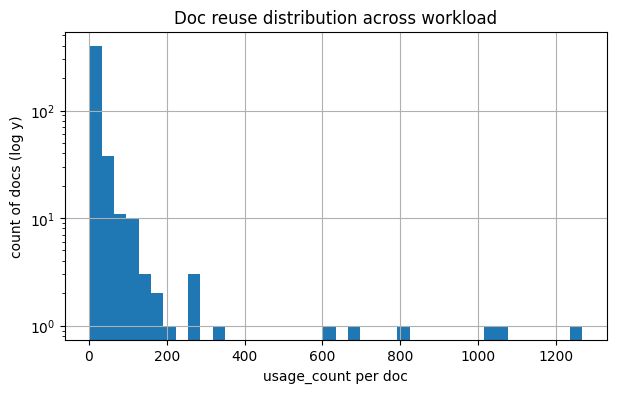

Task usage by doc_type:


doc_type,task_type,count
10K,EXEC_SUMMARY,2611
10K,RISK_FACTORS,2610
10Q,EXEC_SUMMARY,1372
10Q,RISK_FACTORS,1336
CREDIT_AGREEMENT,EXEC_SUMMARY,1354
CREDIT_AGREEMENT,COVENANTS,992
CREDIT_AGREEMENT,TRAPDOOR_CAPACITY,772
INVESTOR_DECK,EXEC_SUMMARY,905
INVESTOR_DECK,GUIDANCE,904
TRANSCRIPT,EXEC_SUMMARY,1109



Task usage by query_type:


query_type,task_type,count
coverage,EXEC_SUMMARY,1961
coverage,RISK_FACTORS,1309
coverage,GUIDANCE,268
coverage,COVENANTS,98
coverage,TRAPDOOR_CAPACITY,89
disruption,EXEC_SUMMARY,2237
disruption,RISK_FACTORS,1413
disruption,GUIDANCE,313
disruption,COVENANTS,303
disruption,TRAPDOOR_CAPACITY,167


In [34]:
# 4.7 Doc + task usage patterns

doc_usage = (
    df_query_pairs.groupby(["doc_id", "doc_type"])
    .size()
    .reset_index(name="usage_count")
    .merge(df_docs[["doc_id", "doc_length_tokens"]], on="doc_id", how="left")
)

print("Top 10 most-used documents:")
pretty_print_table(doc_usage.sort_values("usage_count", ascending=False).head(10))

plt.figure()
plt.hist(doc_usage["usage_count"], bins=40)
plt.yscale("log")
plt.xlabel("usage_count per doc")
plt.ylabel("count of docs (log y)")
plt.title("Doc reuse distribution across workload")
plt.show()


task_by_doc_type = (
    df_query_pairs.groupby(["doc_type", "task_type"])
    .size()
    .reset_index(name="count")
    .sort_values(["doc_type", "count"], ascending=[True, False])
)

print("Task usage by doc_type:")
pretty_print_table(task_by_doc_type.head(20))

task_by_query_type = (
    df_query_pairs.groupby(["query_type", "task_type"])
    .size()
    .reset_index(name="count")
    .sort_values(["query_type", "count"], ascending=[True, False])
)

print("\nTask usage by query_type:")
pretty_print_table(task_by_query_type.head(20))

The workload has the shape we want:

- Skewed doc reuse (few “hot” docs, many cold docs).
- Query mix aligned with personas.
- Task mix aligned with doc_type + query_type.

Next, we compute the **baseline distillation cost** with no caching.

## 5. Baseline Policy: No Doc-Scoped Cache

In [35]:
# 5.1 Baseline: always distill fresh (no reuse)

cols_cost = ["doc_id", "task_type", "tokens_total", "cost", "latency_ms"]

df_work = df_query_pairs.merge(
    df_distill[cols_cost],
    on=["doc_id", "task_type"],
    how="left",
    validate="many_to_one",
)

if df_work["tokens_total"].isna().any():
    raise ValueError(
        "Some (doc_id, task_type) pairs in workload missing from df_distill"
    )

n_usages = len(df_work)
n_queries = CFG.n_queries
n_distinct_pairs_used = df_work[["doc_id", "task_type"]].drop_duplicates().shape[0]

baseline_tokens_total = int(df_work["tokens_total"].sum())
baseline_cost_total = float(df_work["cost"].sum())
baseline_latency_total = float(df_work["latency_ms"].sum())

baseline_summary = pd.DataFrame(
    {
        "metric": [
            "distill_tokens_total",
            "distill_cost_total",
            "distill_latency_total_ms",
            "distill_tokens_per_query",
            "distill_latency_per_query_ms",
        ],
        "value": [
            baseline_tokens_total,
            baseline_cost_total,
            baseline_latency_total,
            baseline_tokens_total / n_queries,
            baseline_latency_total / n_queries,
        ],
    }
)

print(
    f"Baseline workload size: {n_usages:,} distillation calls over {n_queries:,} queries"
)
print(f"Distinct (doc_id, task_type) pairs used: {n_distinct_pairs_used:,}")
pretty_print_table(baseline_summary)

policy_results: Dict[str, Dict[str, float]] = {}
policy_results["baseline"] = {
    "tokens_total": baseline_tokens_total,
    "cost_total": baseline_cost_total,
    "latency_total_ms": baseline_latency_total,
    "tokens_per_query": baseline_tokens_total / n_queries,
    "latency_per_query_ms": baseline_latency_total / n_queries,
    "hits": 0,
    "misses": n_usages,
    "hit_rate": 0.0,
    "n_usages": n_usages,
    "n_distinct_pairs": n_distinct_pairs_used,
}

Baseline workload size: 15,023 distillation calls over 5,000 queries
Distinct (doc_id, task_type) pairs used: 983


metric,value
distill_tokens_total,150321331.000000
distill_cost_total,150.321331
distill_latency_total_ms,3005695.972000
distill_tokens_per_query,30064.266200
distill_latency_per_query_ms,601.139194


## 6. Capacity-Limited Doc Cache (with Eviction)

Now we layer in a doc-scoped cache keyed by `(doc_id, task_type)`:

- On **miss**: pay full distillation cost, insert into cache.
- On **hit**: reuse at ~zero marginal token cost/latency.
- When full: evict via **LRU**.

This lets us compare:

- Baseline (no reuse)
- Finite LRU cache (e.g., K = 200 doc-task views)
- “Unbounded” cache (effectively cache-all for this workload)

In [36]:
# 6.1 Register LRU policies vs baseline

from collections import OrderedDict

def run_cache_policy_lru(capacity: int) -> Dict[str, float]:
    """
    Replay the workload with an LRU cache over (doc_id, task_type).
    capacity = 0 → no cache (baseline semantics, but recomputed).
    capacity >= n_distinct_pairs → effectively unbounded.
    """
    if "df_work" not in globals():
        raise RuntimeError("df_work not defined — run the baseline cell first.")
    
    n_usages = len(df_work)
    n_distinct_pairs = policy_results["baseline"]["n_distinct_pairs"]

    # Treat capacity >= distinct_pairs as unbounded for clarity
    if capacity is None or capacity >= n_distinct_pairs:
        eff_capacity = n_distinct_pairs
    else:
        eff_capacity = max(0, int(capacity))

    cache = OrderedDict()  # key: (doc_id, task_type) → True (we only care about membership)
    hits = misses = 0
    tokens_total = 0
    latency_total = 0.0

    for _, row in df_work.iterrows():
        key = (int(row["doc_id"]), row["task_type"])

        if eff_capacity == 0:
            # No cache at all
            misses += 1
            tokens_total += int(row["tokens_total"])
            latency_total += float(row["latency_ms"])
            continue

        if key in cache:
            hits += 1
            # LRU: mark as most recently used
            cache.move_to_end(key)
            # Distillation view reused → ~zero incremental tokens/latency
        else:
            misses += 1
            tokens_total += int(row["tokens_total"])
            latency_total += float(row["latency_ms"])
            cache[key] = True
            if len(cache) > eff_capacity:
                # Evict least recently used (oldest) entry
                cache.popitem(last=False)

    hit_rate = hits / n_usages if n_usages else 0.0
    baseline_tokens = policy_results["baseline"]["tokens_total"]
    baseline_latency = policy_results["baseline"]["latency_total_ms"]

    return {
        "capacity": eff_capacity,
        "hits": hits,
        "misses": misses,
        "hit_rate": hit_rate,
        "tokens_total": tokens_total,
        "tokens_vs_baseline": tokens_total / baseline_tokens,
        "latency_total_ms": latency_total,
        "latency_vs_baseline": latency_total / baseline_latency,
        "n_usages": n_usages,
        "n_distinct_pairs": n_distinct_pairs,
    }


policy_results["baseline"]["capacity"] = 0
baseline_tokens = policy_results["baseline"]["tokens_total"]
baseline_latency = policy_results["baseline"]["latency_total_ms"]
n_queries = CFG.n_queries


def register_lru_policy(name: str, capacity: int | None):
    """
    Run LRU at given capacity, normalize vs baseline, and stash in policy_results.
    """
    stats = run_cache_policy_lru(capacity=capacity)

    entry = {
        "capacity": stats["capacity"],
        "tokens_total": stats["tokens_total"],
        "cost_total": token_cost(stats["tokens_total"], CFG),
        "latency_total_ms": stats["latency_total_ms"],
        "tokens_per_query": stats["tokens_total"] / n_queries,
        "latency_per_query_ms": stats["latency_total_ms"] / n_queries,
        "hits": stats["hits"],
        "misses": stats["misses"],
        "hit_rate": stats["hit_rate"],
        "n_usages": stats["n_usages"],
        "n_distinct_pairs": stats["n_distinct_pairs"],
    }

    policy_results[name] = entry
    return entry


max_distinct_pairs = policy_results["baseline"]["n_distinct_pairs"]

lru_k_200 = register_lru_policy("lru_k_200", capacity=200)
lru_unbounded = register_lru_policy("lru_unbounded", capacity=max_distinct_pairs)

policy,capacity,hit_rate,tokens_total,tokens_vs_baseline,latency_total_ms,latency_vs_baseline
baseline,0,0.000000,150321331,1.000000,3005695.972000,1.000000
lru_k_200,200,0.674499,39359841,0.261838,863518.092000,0.287294
lru_unbounded,983,0.934567,9091543,0.060481,187738.516000,0.062461


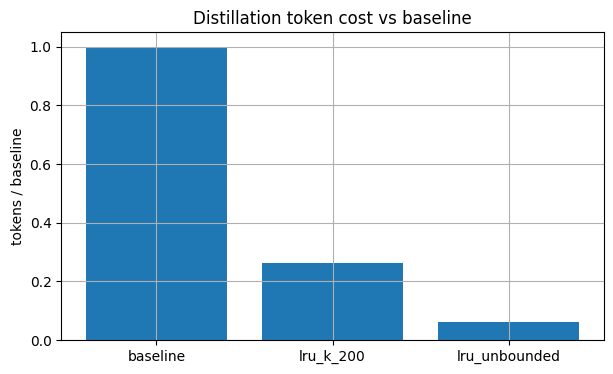

In [37]:
# 6.2 Compact comparison table: baseline vs LRU caches

rows = []
for name in ["baseline", "lru_k_200", "lru_unbounded"]:
    stats = policy_results[name]
    rows.append(
        {
            "policy": name,
            "capacity": stats["capacity"],
            "hit_rate": stats.get("hit_rate", 0.0),
            "tokens_total": stats["tokens_total"],
            "tokens_vs_baseline": stats["tokens_total"] / baseline_tokens,
            "latency_total_ms": stats["latency_total_ms"],
            "latency_vs_baseline": stats["latency_total_ms"] / baseline_latency,
        }
    )

df_policy_compare = pd.DataFrame(rows)
pretty_print_table(df_policy_compare)

plt.figure(figsize=(7, 4))
plt.bar(df_policy_compare["policy"], df_policy_compare["tokens_vs_baseline"])
plt.ylabel("tokens / baseline")
plt.title("Distillation token cost vs baseline")
plt.show()

This gives the high-level story:

- How much a modest cache (K=200) recovers vs baseline.
- How close we can get to the “cache everything once” limit.
- Hit rate vs capacity for this specific hedge-fund-like workload.

## 7. Throughput / Latency Metrics

Next: translate distillation cost into a rough **throughput ceiling**:

- Approx distillation-only latency per query.
- Approx QPS at a fixed concurrency (e.g., 16-way parallelism).

This is deliberately back-of-envelope: just enough to reason about whether the Distillation Agent is the bottleneck in a Deeper Research pipeline.

policy,capacity,hit_rate,distill_tokens_total,distill_tokens_per_query,distill_latency_total_ms,distill_latency_per_query_ms,tokens_vs_baseline,latency_vs_baseline,approx_distill_qps@16
lru_unbounded,983,0.934567,9091543,1818.308600,187738.516000,37.547703,0.060481,0.062461,426.124600
lru_k_200,200,0.674499,39359841,7871.968200,863518.092000,172.703618,0.261838,0.287294,92.644266
baseline,0,0.000000,150321331,30064.266200,3005695.972000,601.139194,1.000000,1.000000,26.616132


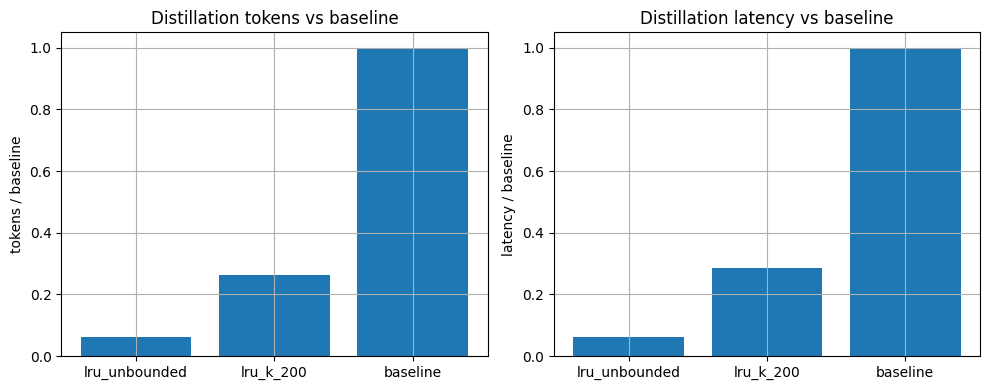

In [38]:
# 7.1 Build metrics table + rough distillation QPS

records = []
concurrency = 16  # assumed parallelism for a quick sanity check

for name, stats in policy_results.items():
    tokens_total = stats["tokens_total"]
    latency_total = stats["latency_total_ms"]

    tokens_per_query = tokens_total / n_queries
    latency_per_query = latency_total / n_queries  # ms

    approx_qps = (
        concurrency * 1000.0 / latency_per_query if latency_per_query > 0 else np.nan
    )

    records.append(
        {
            "policy": name,
            "capacity": stats.get("capacity", np.nan),
            "hit_rate": stats.get("hit_rate", 0.0),
            "distill_tokens_total": tokens_total,
            "distill_tokens_per_query": tokens_per_query,
            "distill_latency_total_ms": latency_total,
            "distill_latency_per_query_ms": latency_per_query,
            "tokens_vs_baseline": tokens_total / baseline_tokens,
            "latency_vs_baseline": latency_total / baseline_latency,
            "approx_distill_qps@16": approx_qps,
        }
    )

df_metrics = pd.DataFrame(records).sort_values("tokens_vs_baseline")
pretty_print_table(df_metrics)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(df_metrics["policy"], df_metrics["tokens_vs_baseline"])
ax[0].set_ylabel("tokens / baseline")
ax[0].set_title("Distillation tokens vs baseline")

ax[1].bar(df_metrics["policy"], df_metrics["latency_vs_baseline"])
ax[1].set_ylabel("latency / baseline")
ax[1].set_title("Distillation latency vs baseline")

plt.tight_layout()
plt.show()

The key outputs:

- How much faster a cached Distillation Agent can serve the same workload.
- Whether the Distillation slice is likely to be the limiting factor once:
  - Retrieval and Matrix execution are optimized.
  - You’re reusing distilled views aggressively for “hot” doc-task pairs.

## 8. Sensitivity Analysis

Now we stress-test the idea:

- How does performance change as we:
  - Vary cache size?
  - Change reuse skew (Zipf exponent)?
  - Introduce simple cache invalidation (docs updating under analysts’ feet)?

This is intentionally coarse: the goal is to understand regime changes, not micro-optimize constants.

LRU cache sensitivity (capacity vs savings):


capacity,hit_rate,tokens_vs_baseline,latency_vs_baseline
0,0.000000,1.000000,1.000000
50,0.395926,0.502550,0.543145
100,0.542834,0.364985,0.401844
200,0.674499,0.261838,0.287294
400,0.813752,0.157233,0.168835
800,0.921720,0.072957,0.075085
983,0.934567,0.060481,0.062461


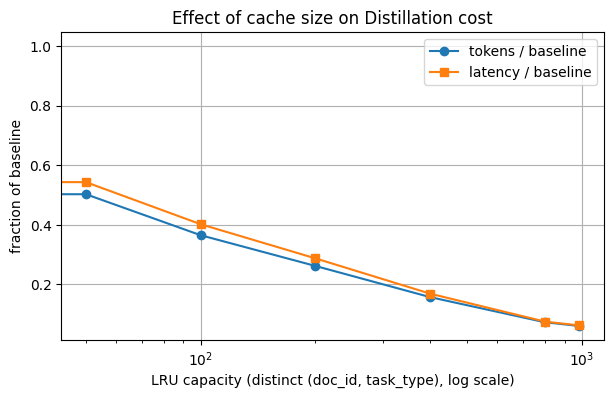

In [39]:
# 8.1 Cache size sweep: tokens/latency vs baseline


def sweep_lru_capacities(capacities: List[int]) -> pd.DataFrame:
    rows = []
    for cap in capacities:
        stats = run_cache_policy_lru(capacity=cap)
        rows.append(
            {
                "capacity": stats["capacity"],
                "hit_rate": stats["hit_rate"],
                "tokens_vs_baseline": stats["tokens_total"] / baseline_tokens,
                "latency_vs_baseline": stats["latency_total_ms"] / baseline_latency,
            }
        )
    return pd.DataFrame(rows).sort_values("capacity")


capacities = [0, 50, 100, 200, 400, 800, max_distinct_pairs]
df_sweep = sweep_lru_capacities(capacities)

# Make capacity=0 line up exactly with baseline
df_sweep.loc[
    df_sweep["capacity"] == 0, ["hit_rate", "tokens_vs_baseline", "latency_vs_baseline"]
] = [
    0.0,
    1.0,
    1.0,
]

print("LRU cache sensitivity (capacity vs savings):")
pretty_print_table(df_sweep)

plt.figure(figsize=(7, 4))
plt.plot(
    df_sweep["capacity"],
    df_sweep["tokens_vs_baseline"],
    marker="o",
    label="tokens / baseline",
)
plt.plot(
    df_sweep["capacity"],
    df_sweep["latency_vs_baseline"],
    marker="s",
    label="latency / baseline",
)
plt.xscale("log")
plt.xlabel("LRU capacity (distinct (doc_id, task_type), log scale)")
plt.ylabel("fraction of baseline")
plt.title("Effect of cache size on Distillation cost")
plt.legend()
plt.grid(True)
plt.show()

Even a small cache (K ≪ number of distinct doc-task pairs) should start to capture most of the “hot head” in a Zipf workload. The curve above shows how quickly we approach the unbounded-cache limit for this synthetic fund.

Sensitivity to workload reuse skew (LRU K=200):


zipf_exponent,hit_rate,tokens_vs_baseline,latency_vs_baseline
0.600000,0.344837,0.519121,0.572786
0.900000,0.541717,0.368563,0.403645
1.100000,0.691568,0.243758,0.269257
1.300000,0.801282,0.156783,0.173302
1.600000,0.911655,0.068752,0.076687


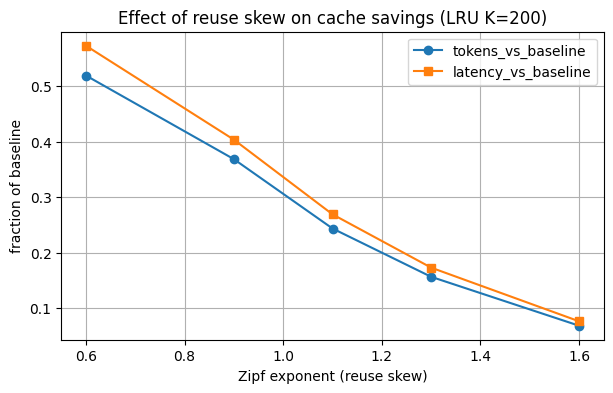

In [40]:
# 8.2 Reuse skew sensitivity: vary Zipf exponent, hold cache K fixed


def run_sensitivity_zipf(zipf_values: List[float], cache_K: int = 200) -> pd.DataFrame:
    """
    For each Zipf exponent:
    - Rebuild doc popularity
    - Regenerate workload
    - Measure LRU-K performance vs the original baseline
    """
    global df_work, DOC_SAMPLING_PROBS

    base_zipf = CFG.zipf_exponent
    base_weights = docs_index["zipf_weight"].copy()
    base_df_work = df_work.copy()

    rows = []

    for z in zipf_values:
        CFG.zipf_exponent = z

        ranks = np.arange(1, len(docs_index) + 1)
        zipf_w = 1.0 / (ranks**z)
        zipf_w = zipf_w / zipf_w.sum()
        docs_index["zipf_weight"] = zipf_w

        DOC_SAMPLING_PROBS = build_doc_sampling_probs(docs_index, QUERY_DOCTYPE_PREFS)

        # Regenerate workload (only doc_id, task_type needed for df_work)
        pairs = []
        for q_id in range(CFG.n_queries):
            analyst_id = np.random.randint(0, N_ANALYSTS)
            qtype = analyst_persona[analyst_id]

            n_docs_q = np.random.randint(
                CFG.min_docs_per_query,
                CFG.max_docs_per_query + 1,
            )
            doc_probs = DOC_SAMPLING_PROBS[qtype]
            doc_indices = np.random.choice(
                len(docs_index),
                size=n_docs_q,
                replace=False,
                p=doc_probs,
            )

            for idx in doc_indices:
                doc_row = docs_index.iloc[idx]
                doc_id = int(doc_row["doc_id"])
                doc_type = doc_row["doc_type"]

                n_tasks = np.random.randint(
                    CFG.min_tasks_per_doc,
                    CFG.max_tasks_per_doc + 1,
                )
                tasks = sample_tasks_for_doc(doc_type, qtype, n_tasks)

                for t in tasks:
                    pairs.append({"doc_id": doc_id, "task_type": t})

        df_pairs_z = pd.DataFrame(pairs)

        df_work = df_pairs_z.merge(
            df_distill[["doc_id", "task_type", "tokens_total", "cost", "latency_ms"]],
            on=["doc_id", "task_type"],
            how="left",
            validate="many_to_one",
        )

        stats = run_cache_policy_lru(capacity=cache_K)

        rows.append(
            {
                "zipf_exponent": z,
                "hit_rate": stats["hit_rate"],
                "tokens_vs_baseline": stats["tokens_total"] / baseline_tokens,
                "latency_vs_baseline": stats["latency_total_ms"] / baseline_latency,
            }
        )

    # Restore original state
    CFG.zipf_exponent = base_zipf
    docs_index["zipf_weight"] = base_weights
    DOC_SAMPLING_PROBS = build_doc_sampling_probs(docs_index, QUERY_DOCTYPE_PREFS)
    df_work = base_df_work

    return pd.DataFrame(rows).sort_values("zipf_exponent")


zipf_vals = [0.6, 0.9, 1.1, 1.3, 1.6]
df_zipf = run_sensitivity_zipf(zipf_vals, cache_K=200)

print("Sensitivity to workload reuse skew (LRU K=200):")
pretty_print_table(df_zipf)

plt.figure(figsize=(7, 4))
plt.plot(
    df_zipf["zipf_exponent"],
    df_zipf["tokens_vs_baseline"],
    marker="o",
    label="tokens_vs_baseline",
)
plt.plot(
    df_zipf["zipf_exponent"],
    df_zipf["latency_vs_baseline"],
    marker="s",
    label="latency_vs_baseline",
)
plt.xlabel("Zipf exponent (reuse skew)")
plt.ylabel("fraction of baseline")
plt.title("Effect of reuse skew on cache savings (LRU K=200)")
plt.legend()
plt.grid(True)
plt.show()

As reuse becomes peakier (higher Zipf exponent), a small cache should capture more of the workload. This is the regime Hebbia naturally lives in: a handful of very hot documents, then a long tail.

Sensitivity to simple cache invalidation (LRU K=200):


invalidate_prob,hit_rate,tokens_vs_baseline,latency_vs_baseline
0.000000,0.674499,0.261838,0.287294
0.010000,0.342009,0.579758,0.611040
0.050000,0.147707,0.805468,0.824192
0.100000,0.083339,0.890261,0.900817
0.200000,0.033948,0.955071,0.959462


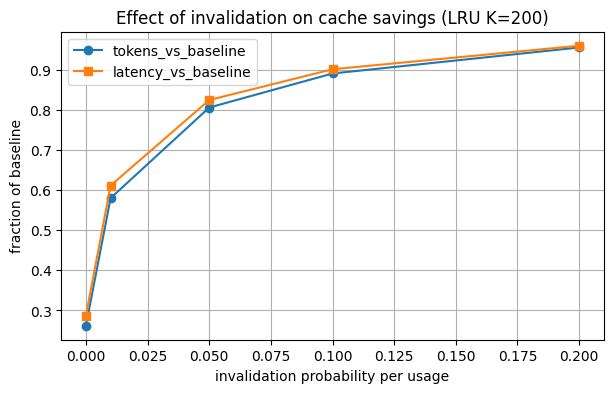

In [41]:
# 8.3 Cache invalidation sensitivity: random “doc updated” events


def run_sensitivity_invalidation(
    invalidate_rates: List[float], cache_K: int = 200
) -> pd.DataFrame:
    """
    Approximate document updates by randomly nuking the cache
    with probability p per query-doc-task step.
    """
    df_pairs = df_query_pairs[["doc_id", "task_type"]]
    rows = []

    for p in invalidate_rates:
        hits = misses = 0
        tokens = 0
        lat = 0.0
        cache = OrderedDict()

        for _, r in df_pairs.iterrows():
            # Random invalidation to mimic doc updates / new versions
            if random.random() < p:
                cache.clear()

            key = (int(r.doc_id), r.task_type)

            if key in cache:
                hits += 1
                cache.move_to_end(key)
            else:
                misses += 1
                row = df_distill[
                    (df_distill.doc_id == r.doc_id)
                    & (df_distill.task_type == r.task_type)
                ].iloc[0]
                tokens += int(row.tokens_total)
                lat += float(row.latency_ms)
                cache[key] = True
                if len(cache) > cache_K:
                    cache.popitem(last=False)

        rows.append(
            {
                "invalidate_prob": p,
                "hit_rate": hits / (hits + misses),
                "tokens_vs_baseline": tokens / baseline_tokens,
                "latency_vs_baseline": lat / baseline_latency,
            }
        )

    return pd.DataFrame(rows).sort_values("invalidate_prob")


invalidate_rates = [0.0, 0.01, 0.05, 0.1, 0.2]
df_inval = run_sensitivity_invalidation(invalidate_rates, cache_K=200)

print("Sensitivity to simple cache invalidation (LRU K=200):")
pretty_print_table(df_inval)

plt.figure(figsize=(7, 4))
plt.plot(
    df_inval["invalidate_prob"],
    df_inval["tokens_vs_baseline"],
    marker="o",
    label="tokens_vs_baseline",
)
plt.plot(
    df_inval["invalidate_prob"],
    df_inval["latency_vs_baseline"],
    marker="s",
    label="latency_vs_baseline",
)
plt.xlabel("invalidation probability per usage")
plt.ylabel("fraction of baseline")
plt.title("Effect of invalidation on cache savings (LRU K=200)")
plt.legend()
plt.grid(True)
plt.show()

This is obviously a toy invalidation model, but it shows how fast savings decay as the underlying documents churn. The real system would use structured invalidation (per-view, per-entity, per-section), which should be strictly better than this “nuke-and-rebuild” toy.

## 9. Hebbia-Scale Interpretation

The [**Context Distillation Agent**](https://www.hebbia.com/blog/inside-hebbias-deeper-research-agent) is doing the heavy lifting to compress sprawling filings, agreements, and transcripts into reusable, structured views. [“How Hedge Funds Use Hebbia”](https://www.hebbia.com/blog/how-hedge-funds-use-hebbia) makes it clear that analysts repeatedly analyze the same small set of credit agreements, 10-Ks, 10-Qs, transcripts, and decks across:
  - coverage ramp
  - value-chain / read-through
  - disruption monitoring
  - expert call prep

In that regime:

- A doc-task cache that fits only a tiny fraction of all possible `(doc_id, task_type)` pairs still captures most of the Distillation Agent’s burn.
- An “unbounded” cache (for a given workload window) is effectively paying each distillation cost once, then amortizing it across all multi-agent queries that touch that doc-task.
- The Distillation Agent starts to look like a **precompute layer** under Matrix and the Deeper Research Agent, not a per-query bottleneck:
  - New filings / agreements -> distill once.
  - Multi-week deal work + cross-fund reuse -> leverage the same doc-task cache.
- The key is not `(prompt, answer)` but `(doc, task, view_schema)`.
- The consumer is not just one chat thread, but every agent in the research graph that needs that structured view.

## 10. Limitations & Extensions

This notebook is deliberately narrow: a sandbox for the Distillation slice only.

**Not modeled:**

- Hierarchical distillation:
  - Separate caches for global summary, covenant tree, risk vectors, tone embeddings, ISD segments, etc.
  - Partial invalidation (only risk factors, only forward guidance) instead of nuking whole doc-task views.
- Multi-agent memory:
  - Planner / retriever / comparator agents also produce reusable artifacts (entity graphs, table normalizations, cross-doc joins).
  - Those could sit on top of the same document scope cache or in a parallel “analysis cache.”
- Real invalidation triggers:
  - New filings, new transcripts, updated guidance, internal notes.
  - Schema-aware invalidation keyed to ISD segment IDs and doc versions.
- Scheduling and routing:
  - This notebook ignores Maximizer-style routing, token buckets, and rate-limit-aware scheduling.
  - In a full system, you’d couple this cache to:
    - per-model token budgets
    - prioritization (hot deals, PM-pinned views, IC memos in progress)
    - multi-tenant fairness.

**Next steps I care about:**

- Treat this as a lower-bound model for a **document scope cache** under the Distillation Agent.
- Plug real traffic from a smaller-scale research stack (or a Hebbia-like OSS clone) into the same harness.
- Layer in:
  - view schemas (per-task structured outputs)
  - multi-level caches (doc, section, entity)
  - more realistic invalidation keyed to doc versions and ISD chunk IDs.